## 1. Loading test images

In [1]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.video.io.VideoFileClip import VideoFileClip

%matplotlib inline

In [2]:
def list_images(images, cols=2, rows=5, cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
    """
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

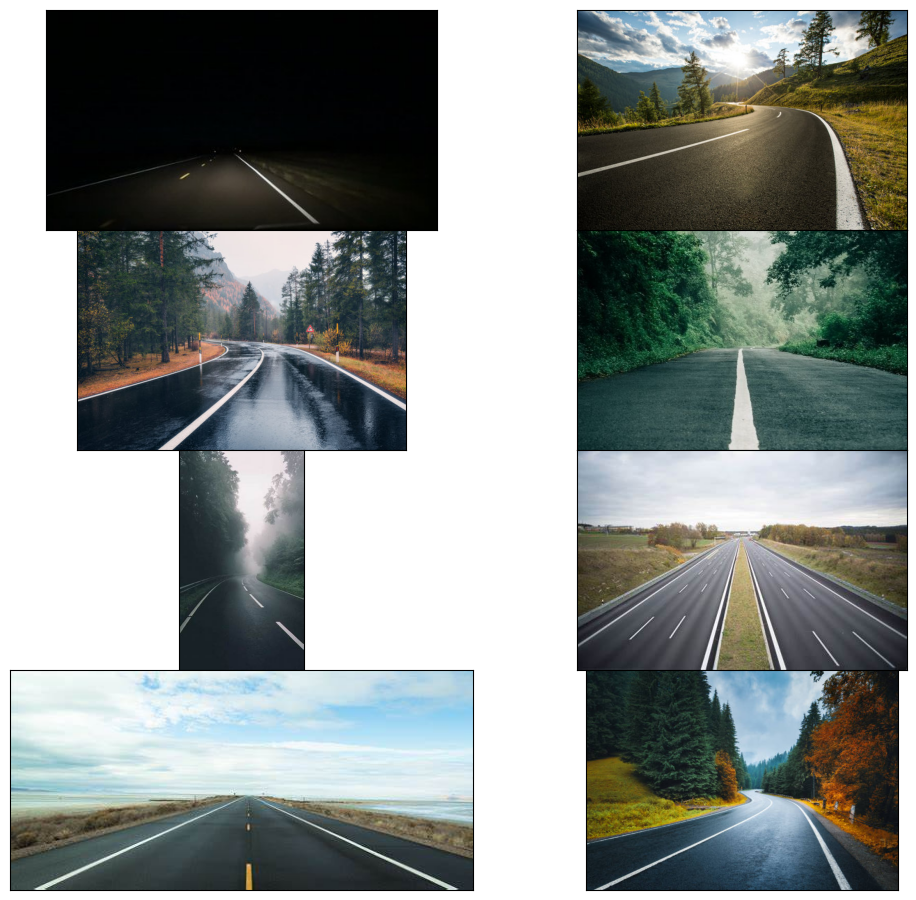

In [3]:
if os.path.exists('test_images'):
    test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
    list_images(test_images)
else:
    print("Error: 'test_images' folder not found.")

## 2. Color Selection

In [4]:
def RGB_color_selection(image):
    """
    Apply color selection to RGB images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #White color mask
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

Applying color selection to `test_images` in the RGB color space.

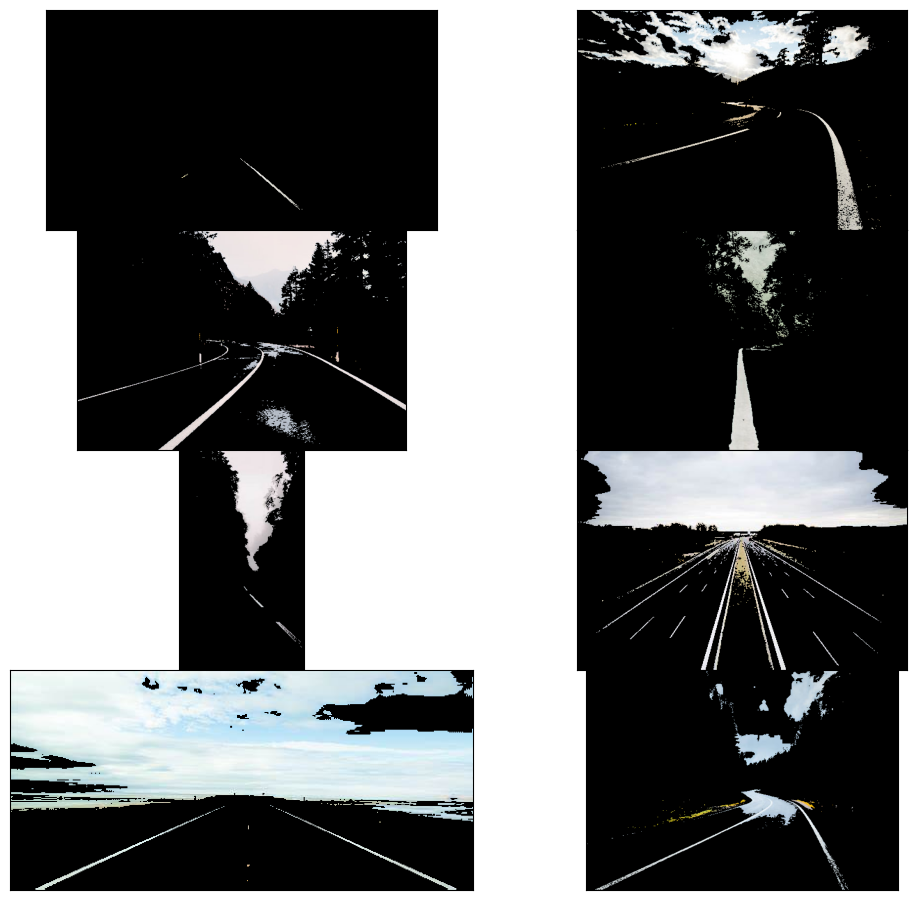

In [5]:
list_images(list(map(RGB_color_selection, test_images)))

### a) HSV color space

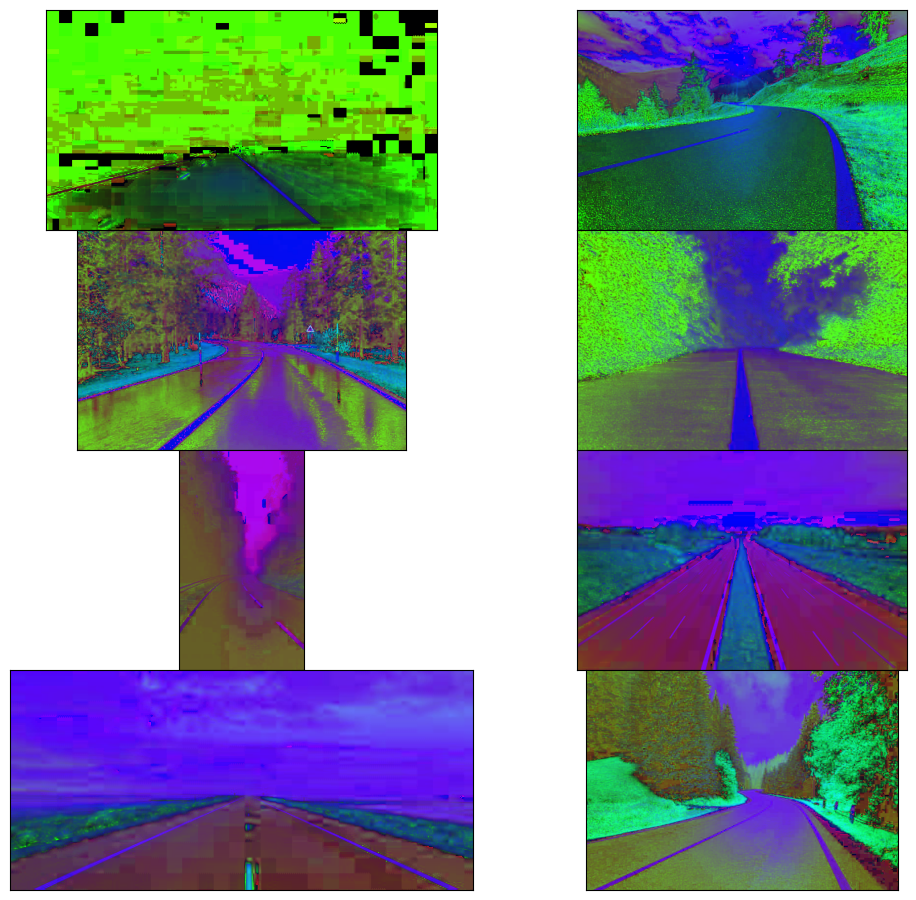

In [6]:
def convert_hsv(image):
    """
    Convert RGB images to HSV.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

list_images(list(map(convert_hsv, test_images)))

In [7]:
def HSV_color_selection(image):
    """
    Apply color selection to the HSV images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSV
    converted_image = convert_hsv(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 0, 210])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([18, 80, 80])
    upper_threshold = np.uint8([30, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

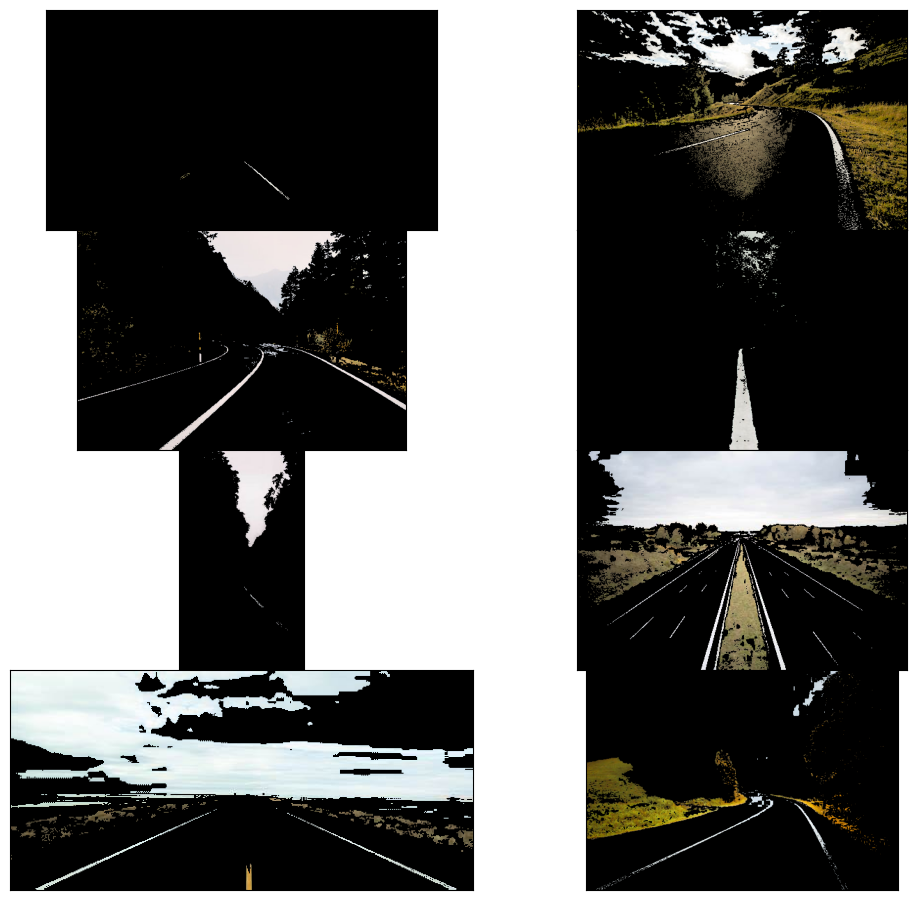

In [8]:
list_images(list(map(HSV_color_selection, test_images)))

### c) HSL color space

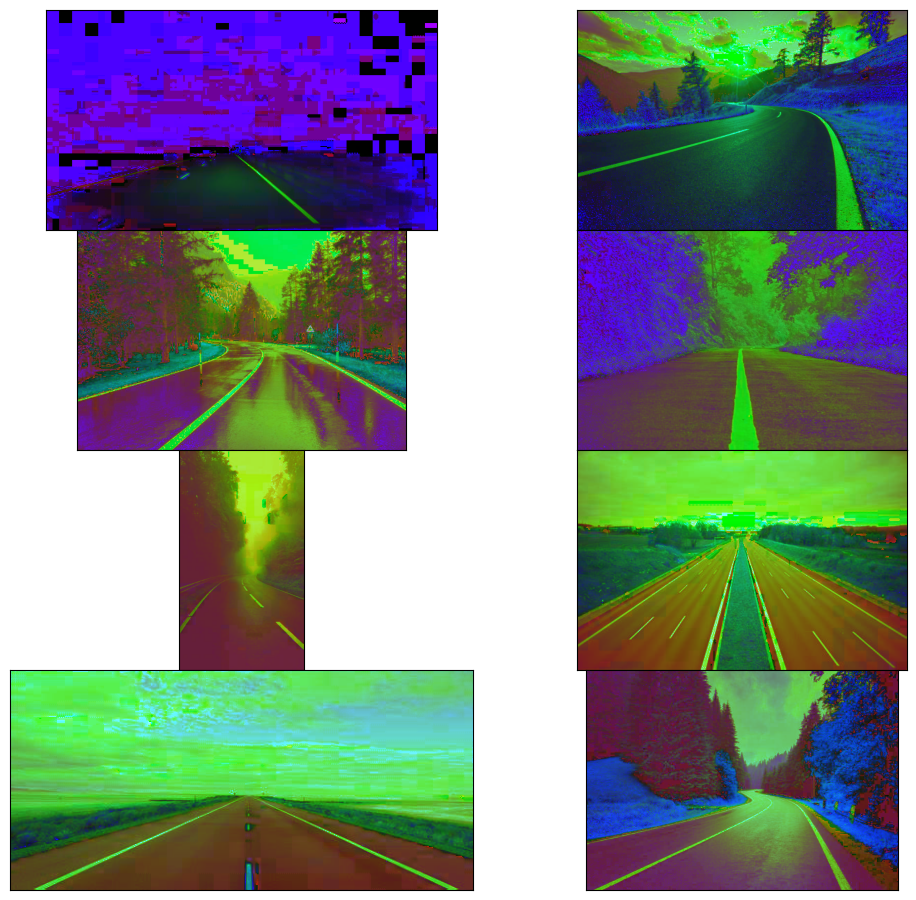

In [9]:
def convert_hsl(image):
    """
    Convert RGB images to HSL.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

list_images(list(map(convert_hsl, test_images)))

In [10]:
def HSL_color_selection(image):
    """
    Apply color selection to the HSL images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSL
    converted_image = convert_hsl(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

Applying color selection to `test_images` in the HSL color space.

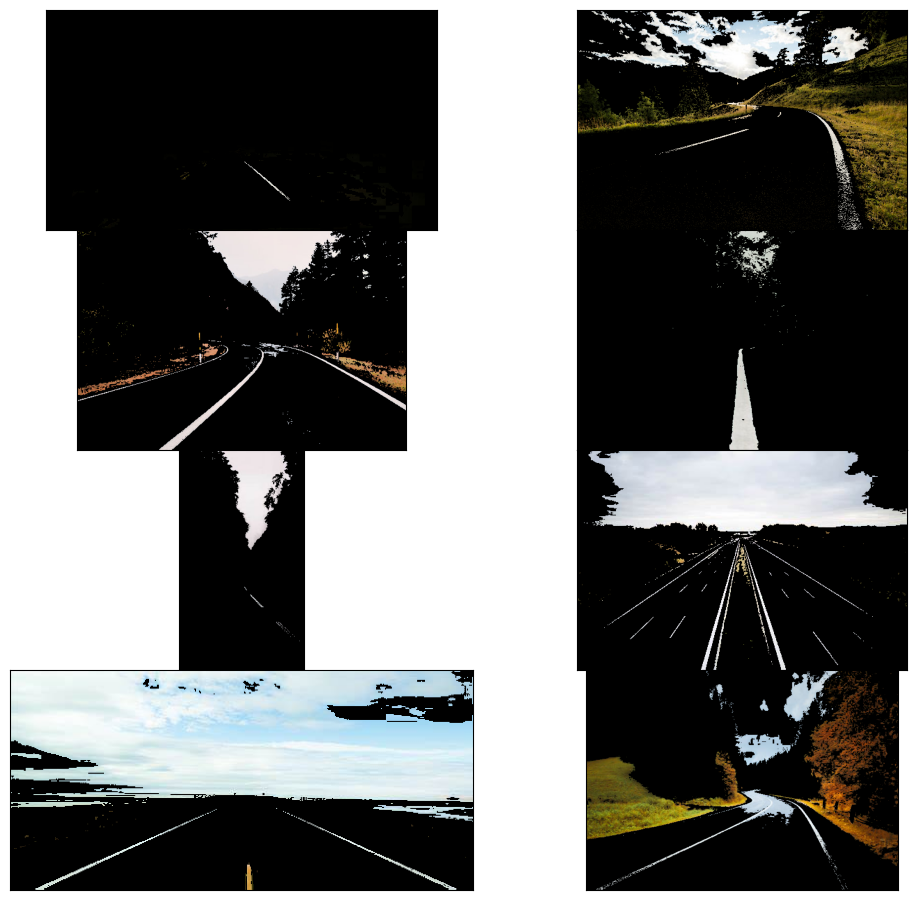

In [11]:
list_images(list(map(HSL_color_selection, test_images)))

In [ ]:
color_selected_images = list(map(HSL_color_selection, test_images))

## 3. Canny Edge Detection

### a) Gray scaling the images

In [7]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [ ]:
gray_image=(list(map(gray_scale, color_selected_images)))
list_images = (gray_image)


### b) Applying Gaussian smoothing

In [15]:
def gaussian_smoothing(image, kernel_size = 13):
    """
    Apply Gaussian filter to the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            kernel_size (Default = 13): The size of the Gaussian kernel will affect the performance of the detector.
            It must be an odd number (3, 5, 7, ...).
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [ ]:
blur_images = list(map(gaussian_smoothing, gray_images))
list_images(blur_images)

### c) Applying Canny Edge Detection

In [8]:
def canny_detector(image, low_threshold = 50, high_threshold = 150):
    """
    Apply Canny Edge Detection algorithm to the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            low_threshold (Default = 50).
            high_threshold (Default = 150).
    """
    return cv2.Canny(image, low_threshold, high_threshold)

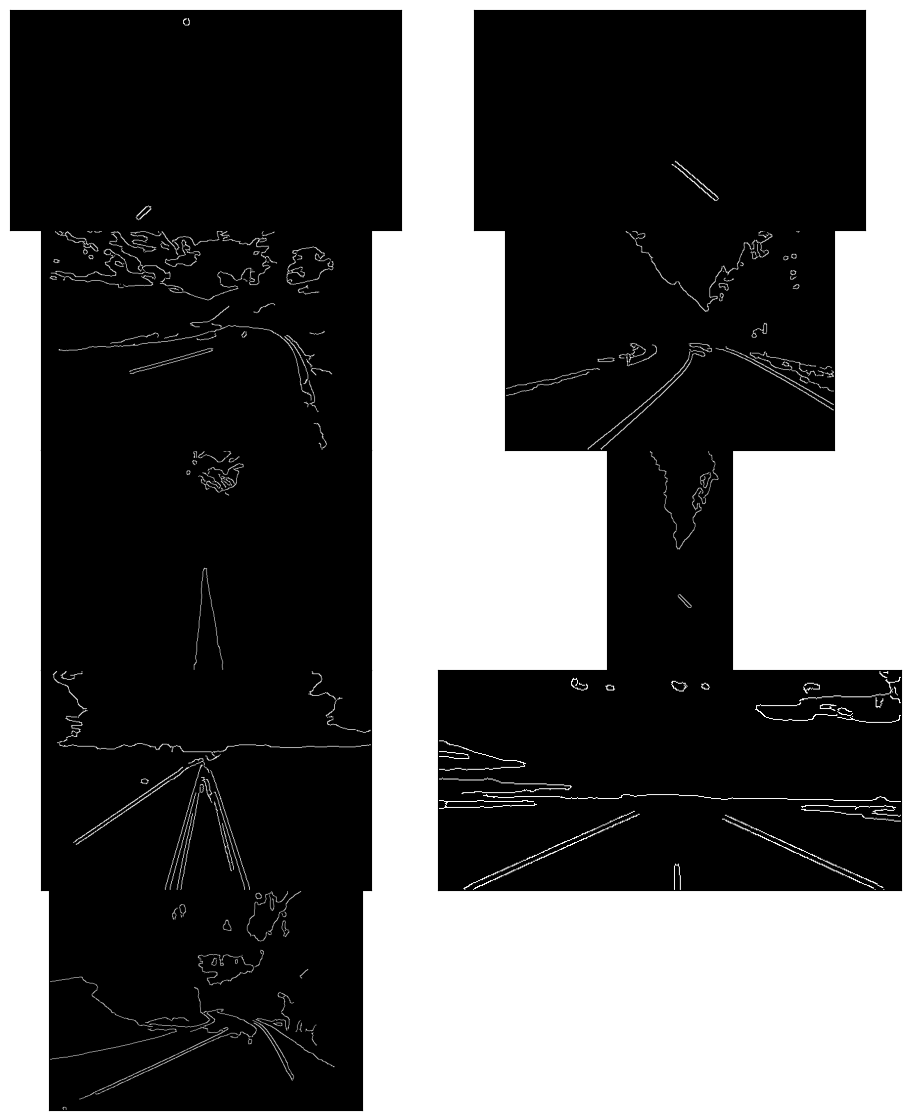

In [115]:
edge_detected_images = list(map(canny_detector, blur_images))
list_images(edge_detected_images)

## 4. Region of interest

In [116]:
def region_selection(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    mask = np.zeros_like(image)   
    #Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #We could have used fixed numbers as the vertices of the polygon,
    #but they will not be applicable to images with different dimesnions.
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

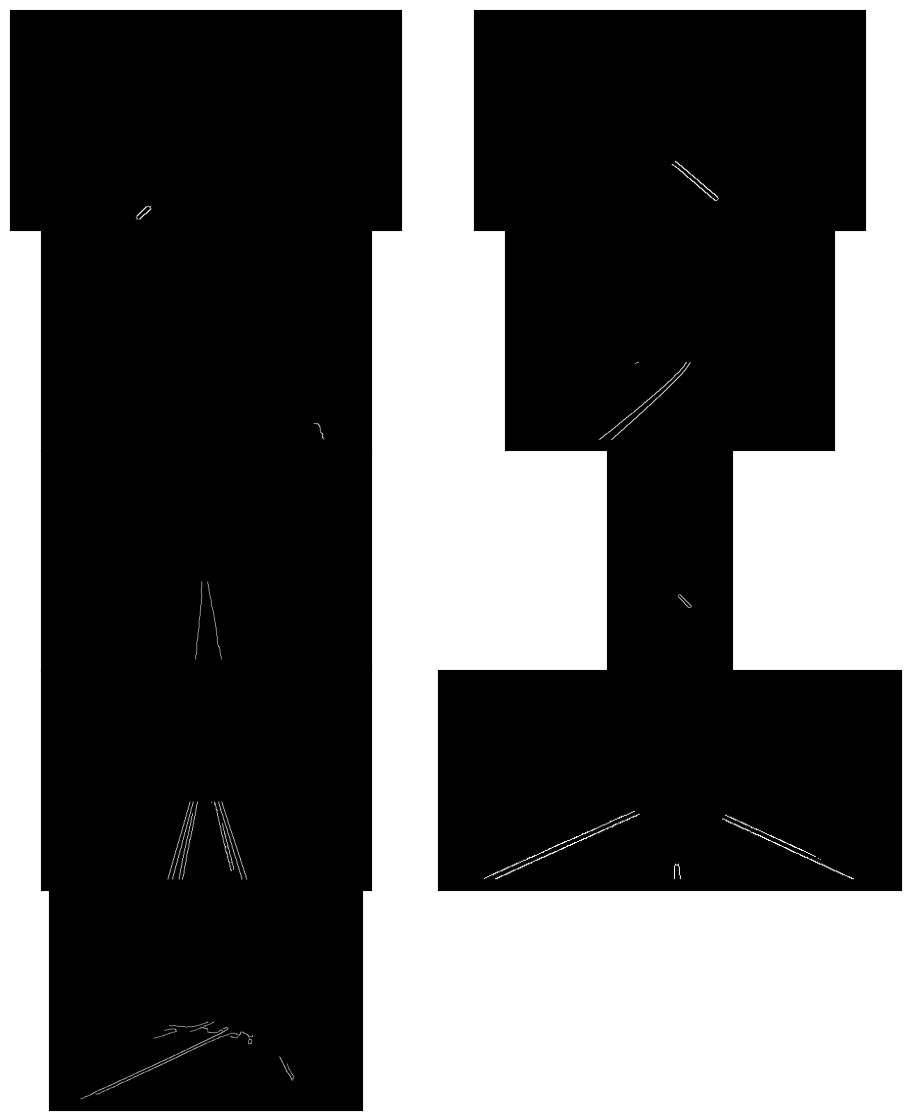

In [117]:
masked_image = list(map(region_selection, edge_detected_images))
list_images(masked_image)

## 5. Hough Transform

In [118]:
def hough_transform(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: The output of a Canny transform.
    """
    rho = 1              #Distance resolution of the accumulator in pixels.
    theta = np.pi/180    #Angle resolution of the accumulator in radians.
    threshold = 20       #Only lines that are greater than threshold will be returned.
    minLineLength = 20   #Line segments shorter than that are rejected.
    maxLineGap = 300     #Maximum allowed gap between points on the same line to link them
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

In [119]:
hough_lines = list(map(hough_transform, masked_image))

In [120]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2):
    """
    Draw lines onto the input image.
        Parameters:
            image: Input image (NumPy array).
            lines: List of lines (output of Hough transform).
            color (Default = [255, 0, 0]): Line color (BGR format).
            thickness (Default = 2): Line thickness.
    """
    image = np.copy(image)
    if lines is not None:  # Check if lines is None
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

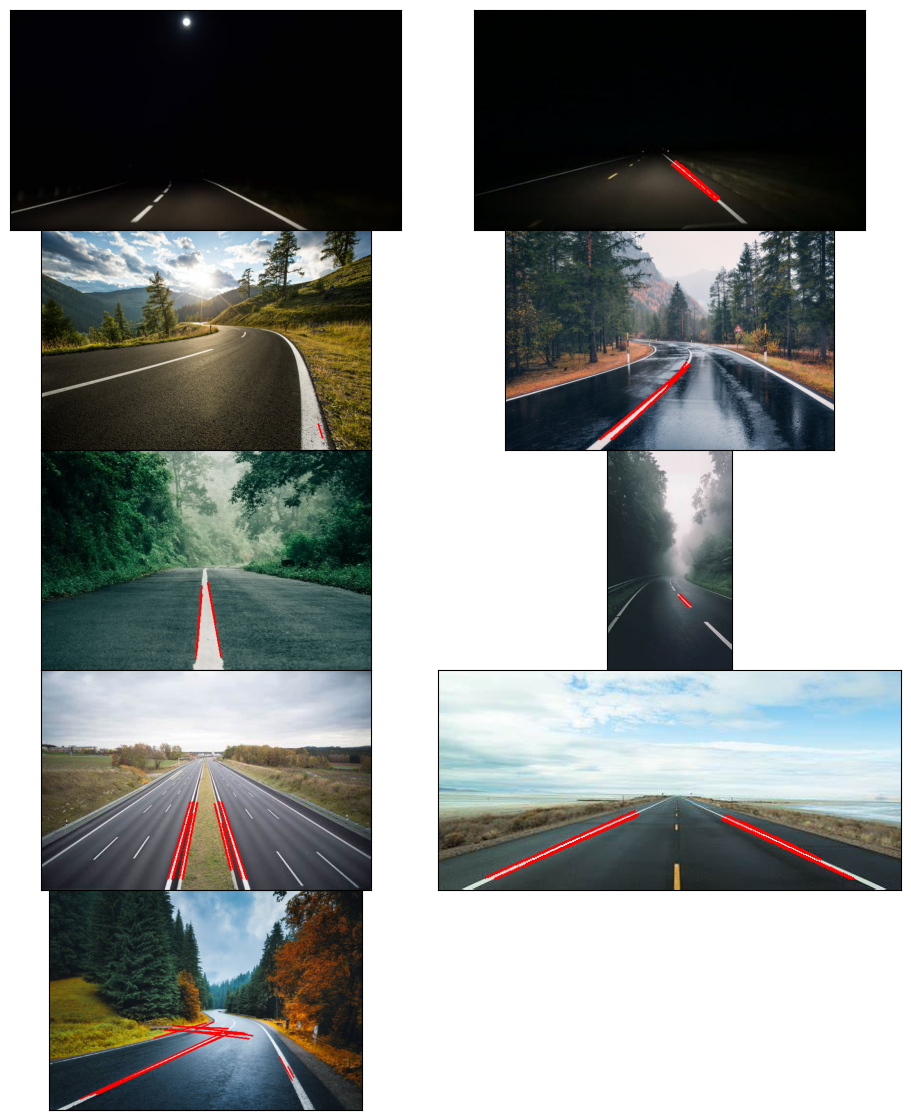

In [121]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    if lines is not None: # check if lines is none before drawing.
        line_images.append(draw_lines(image, lines))
    else:
        line_images.append(image) #Or handle the none case in a different way.
list_images(line_images)

## 6. Averaging and extrapolating the lane lines

In [122]:
def average_slope_intercept(lines):
    """
    Calculates the average slope and intercept for left and right lane lines.
    """
    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)

    if lines is not None: #add this check.
        for line in lines:
            for x1, y1, x2, y2 in line:
                if x1 == x2:
                    continue # ignore a vertical line
                slope = (y2 - y1) / (x2 - x1)
                intercept = y1 - slope * x1
                length = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
                if slope < 0: # left lane
                    left_lines.append((slope, intercept))
                    left_weights.append((length))
                else: # right lane
                    right_lines.append((slope, intercept))
                    right_weights.append((length))

        # ... (rest of your averaging logic) ...
        # ... (return left_lane and right_lane) ...
        left_lane  = None
        right_lane = None
        if len(left_weights) > 0:
            left_lane = np.average(left_lines, axis=0, weights=left_weights)
        if len(right_weights) > 0:
            right_lane = np.average(right_lines, axis=0, weights=right_weights)

        return left_lane, right_lane
    else:
        return None, None #Return None, None if lines is None

In [123]:
def pixel_points(y1, y2, line):
    """
    Converts the slope and intercept of each line into pixel points.
        Parameters:
            y1: y-value of the line's starting point.
            y2: y-value of the line's end point.
            line: The slope and intercept of the line.
    """
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

In [124]:
def lane_lines(image, lines):
    """
    Create full length lines from pixel points.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
    """
    if lines is not None:
        left_lane, right_lane = average_slope_intercept(lines)
        if left_lane is not None and right_lane is not None:
            y1 = image.shape[0]
            y2 = int(y1 * 0.6)  # Convert to integer
            left_slope, left_intercept = left_lane
            right_slope, right_intercept = right_lane

            # Calculate x values for left lane
            left_x1 = int((y1 - left_intercept) / left_slope)
            left_x2 = int((y2 - left_intercept) / left_slope)

            # Calculate x values for right lane
            right_x1 = int((y1 - right_intercept) / right_slope)
            right_x2 = int((y2 - right_intercept) / right_slope)

            # Return lines in the format expected by draw_lines
            return [[[left_x1, y1, left_x2, y2]], [[right_x1, y1, right_x2, y2]]]
        else:
            return None
    else:
        return None

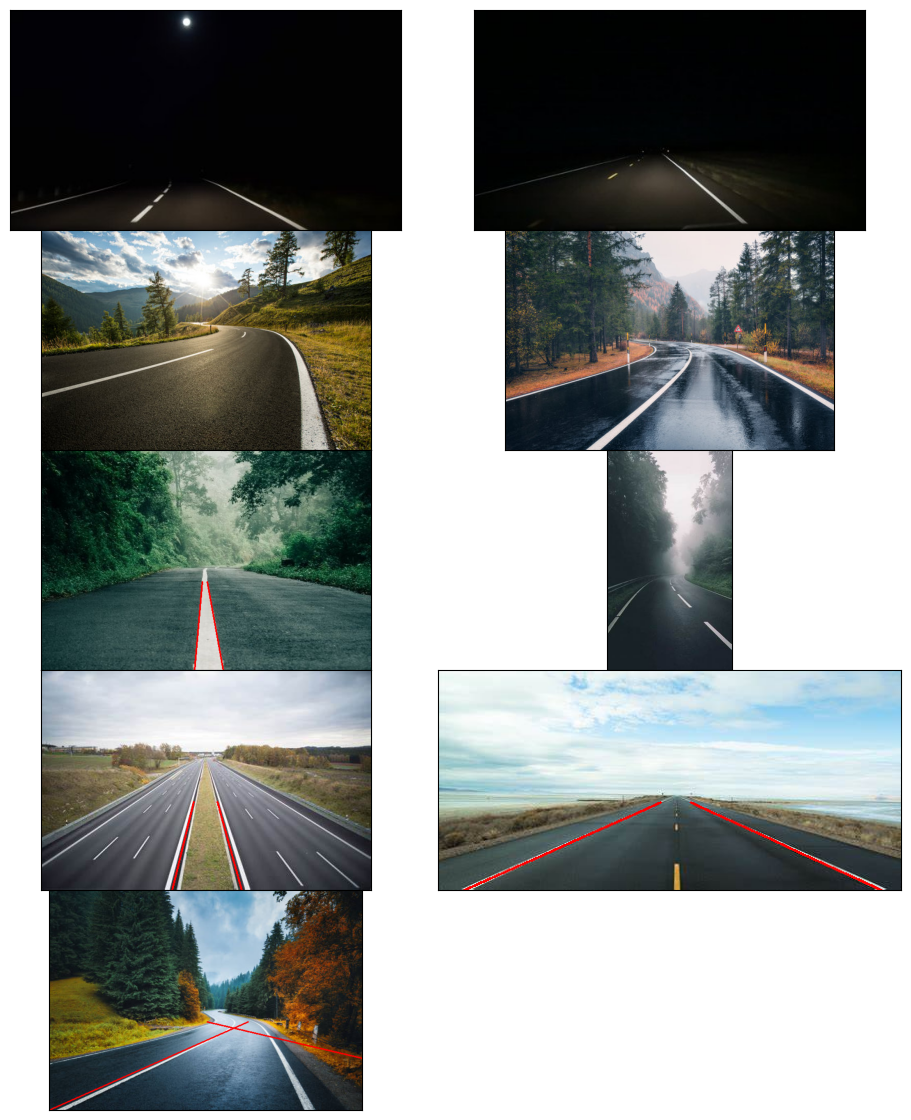

In [125]:
lane_images = []
for image, lines in zip(test_images, hough_lines):
    lane_result = draw_lines(image, lane_lines(image, lines))
    if lane_result is not None:
        lane_images.append(lane_result)
    else:
        lane_images.append(image) #or handle it differently.
list_images(lane_images)

## 7. Apply on video streams

In [126]:
#Import everything needed to edit/save/watch video clips
import os
import glob
import matplotlib.pyplot as plt
from moviepy.video.io.VideoFileClip import VideoFileClip
import numpy as np #Example of frame processor import.
import cv2 #Example of frame processor import.
from IPython.display import HTML

In [127]:
def process_frame(image):
    """
    Process a single frame of the video. (Replace with your actual lane detection logic)
    """

    # Example: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Example: Apply Gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Example: Canny edge detection
    edges = cv2.Canny(blur, 50, 150)
    # Example: Hough transform (replace with your lane detection)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 5)

    return image



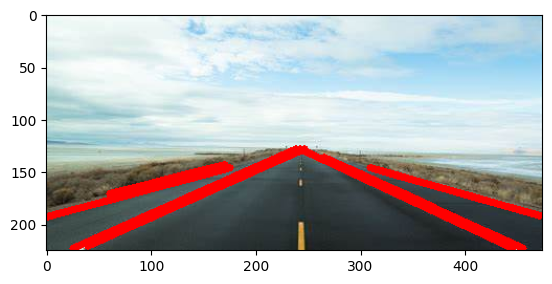

In [128]:
image_path = 'test_images\image.jpg'
if os.path.exists(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed_image = process_frame(image)
        plt.imshow(processed_image)
        plt.show()
    else:
        print(f"Error: Could not load image from {image_path}")
else:
    print(f"Error: File not found at {image_path}")

In [129]:
def process_video(input_video_path, output_video_path):
    """
    Process the video and save the output.
    """
    input_clip = VideoFileClip(input_video_path)
    output_clip = input_clip.fl(process_frame)
    output_clip.write_videofile(output_video_path, audio=False)


In [130]:
def frame_processor(image):
    """
    Process the input frame to detect lane lines.
        Parameters:
            image: Single video frame.
    """
    # Access image attributes
    height, width, channels = image.shape
    data_type = image.dtype
    total_pixels = image.size

    # Example: Print the attributes
    print(f"Image shape: {image.shape}")
    print(f"Image data type: {image.dtype}")
    print(f"Total pixels: {image.size}")

    color_select = HSL_color_selection(image)
    gray         = gray_scale(color_select)
    smooth       = gaussian_smoothing(gray)
    edges        = canny_detector(smooth)
    region       = region_selection(edges)
    hough        = hough_transform(region)
    result       = draw_lines(image, lane_lines(image, hough))

    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)) #Convert to RGB
    plt.show()
    return result 

Image shape: (225, 474, 3)
Image data type: uint8
Total pixels: 319950


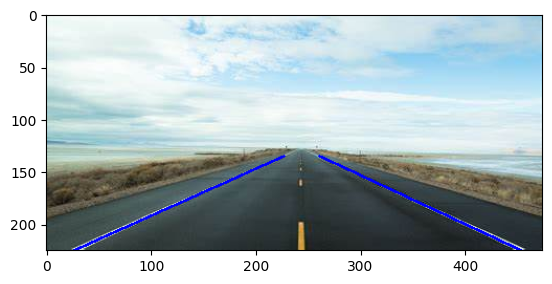

In [131]:
image = cv2.imread('test_images\image.jpg')  # Replace with your image path
processed_image = frame_processor(image)

In [132]:
def process_video(input_video_path, output_video_path):
    """
    Process the video stream and save the output.
    """
    input_clip = VideoFileClip(input_video_path)
    output_clip = input_clip.fl(frame_processor)
    output_clip.write_videofile(output_video_path, audio=False)

In [133]:
def process_live_video(output_video_path="output_videos\challenge_output.mp4"):
    """
    Process a live video stream from the webcam.
    """
    cap = cv2.VideoCapture(0)  # 0 represents the default camera

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # or 'XVID'
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0 #Get fps, or default to 30.0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video stream")
            break

        processed_frame = frame_processor(frame)
        out.write(processed_frame)

        cv2.imshow('Live Lane Detection', processed_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [134]:
def process_video(test_video, output_video, frame_processor):
    """
    Read input video stream and produce a video file with detected lane lines.
        Parameters:
            test_video: Input video.
            output_video: A video file with detected lane lines.
    """
    input_video = VideoFileClip(os.path.join('test_videos', test_video), audio=False)
    processed = input_video.fl(frame_processor)  # Replace fl_image with fl
    processed.write_videofile(os.path.join('output_videos', output_video), audio=False)

# Example Usage (assuming frame_processor is defined elsewhere)
# process_video('solidWhiteRight.mp4', 'solidWhiteRight_output.mp4', frame_processor)

In [135]:
%time process_video('solidWhiteRight.mp4', 'solidWhiteRight_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\solidWhiteRight_output.mp4"))

TypeError: process_video() missing 1 required positional argument: 'frame_processor'

In [136]:
%time process_video('solidYellowLeft.mp4', 'solidYellowLeft_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\solidYellowLeft_output.mp4"))

TypeError: process_video() missing 1 required positional argument: 'frame_processor'

In [137]:
%time process_video('challenge.mp4', 'challenge_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\challenge_output.mp4"))

TypeError: process_video() missing 1 required positional argument: 'frame_processor'